In [1]:
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras import backend as K
from imutils import paths
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import pickle
import cv2
import os

In [2]:
dataset_path = 'dataset_animals'
model_path = os.path.sep.join(['output', 'animal.model'])
le_path = os.path.sep.join(['output', 'le.pickle'])

In [3]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 32
IMAGE_DIMS =  (224, 224, 3)

In [4]:
data = []
labels = []

In [5]:
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(0)
random.shuffle(imagePaths)


In [6]:
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    assert os.path.isfile(imagePath)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-1]
    label = label.split('-')[0]
    labels.append(label)
    #print(label)

In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 75% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, random_state=0, stratify=labels)

data matrix: 2322.60MB


In [8]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [9]:
# experimenting with different batch size
def bs_experiment():
    
    history = []
    
    for bs in [64, 32, 16, 4]:
        input_tensor = Input(shape=IMAGE_DIMS)
    
         # grab the Keras built-in model for transfer learning
        base_model = MobileNetV2(
              include_top=False,
              weights='imagenet',
              input_tensor=input_tensor,
              input_shape=IMAGE_DIMS,
              pooling='avg')
    
        head_model = base_model.output
        head_model = Flatten(name = 'flatten')(head_model)
        head_model = Dense(512, activation = 'relu')(head_model)
        head_model = Dropout(0.5)(head_model)
    
        output_tensor = Dense(10, activation='softmax')(head_model)
    
        model = Model(inputs=input_tensor, outputs=output_tensor)
    
        for layer in base_model.layers:
            layer.trainable = False
    
        model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
        h = model.fit_generator(
              aug.flow(trainX, trainY, batch_size=bs),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // bs,
              epochs=50, verbose=1)
        history.append(h)
    
    return history

history = bs_experiment()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
23/23 [==============================] - 64s 3s/step - loss: 2.2945 - accuracy: 0.2329 - top_k_categorical_accuracy: 0.6860 - val_loss: 1.4315 - val_accuracy: 0.5810 - val_top_k_categorical_accuracy: 0.9494
Epoch 2/50
23/23 [==============================] - 56s 2s/step - loss: 1.4024 - accuracy: 0.5363 - top_k_categorical_accuracy: 0.9238 - val_loss: 0.9780 - val_accuracy: 0.7267 - val_top_k_categorical_accuracy: 0.9879
Epoch 3/50
23/23 [==============================] - 58s 3s/step - loss: 1.0608 - accuracy: 0.6556 - top_k_categorical_accuracy: 0.9675 - val_loss: 0.7775 - val_accuracy: 0.7753 - val_top_k_categorical_accuracy: 0.9879
Epoch 4/50
23/23 [==============================] - 57s 2s/step - loss: 0.8685 - accuracy: 0.7212 - top_k_categorical_accuracy: 0.9809 - val_loss: 0.6638 - val_accuracy: 0.7935 - val_top_k_categorical_accuracy: 0.9939
Epoch 5/50
23/23 [==============================] - 

23/23 [==============================] - 31s 1s/step - loss: 0.2178 - accuracy: 0.9210 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3610 - val_accuracy: 0.8704 - val_top_k_categorical_accuracy: 0.9960
Epoch 38/50
23/23 [==============================] - 31s 1s/step - loss: 0.2222 - accuracy: 0.9224 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.8745 - val_top_k_categorical_accuracy: 0.9960
Epoch 39/50
23/23 [==============================] - 31s 1s/step - loss: 0.2201 - accuracy: 0.9217 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3662 - val_accuracy: 0.8725 - val_top_k_categorical_accuracy: 0.9960
Epoch 40/50
23/23 [==============================] - 31s 1s/step - loss: 0.2206 - accuracy: 0.9273 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3600 - val_accuracy: 0.8745 - val_top_k_categorical_accuracy: 0.9960
Epoch 41/50
23/23 [==============================] - 31s 1s/step - loss: 0.1958 - accuracy: 0.9365 - top_k_categorical_accuracy: 0.9993 

46/46 [==============================] - 32s 693ms/step - loss: 0.2309 - accuracy: 0.9241 - top_k_categorical_accuracy: 0.9979 - val_loss: 0.3552 - val_accuracy: 0.8866 - val_top_k_categorical_accuracy: 0.9960
Epoch 25/50
46/46 [==============================] - 32s 695ms/step - loss: 0.2253 - accuracy: 0.9199 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3515 - val_accuracy: 0.8806 - val_top_k_categorical_accuracy: 0.9960
Epoch 26/50
46/46 [==============================] - 32s 691ms/step - loss: 0.2219 - accuracy: 0.9206 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.3679 - val_accuracy: 0.8765 - val_top_k_categorical_accuracy: 0.9939
Epoch 27/50
46/46 [==============================] - 32s 698ms/step - loss: 0.2147 - accuracy: 0.9241 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.3689 - val_accuracy: 0.8887 - val_top_k_categorical_accuracy: 0.9939
Epoch 28/50
46/46 [==============================] - 32s 693ms/step - loss: 0.1978 - accuracy: 0.9337 - top_k_categorical_ac

Epoch 11/50
92/92 [==============================] - 33s 362ms/step - loss: 0.3253 - accuracy: 0.8867 - top_k_categorical_accuracy: 0.9986 - val_loss: 0.3732 - val_accuracy: 0.8725 - val_top_k_categorical_accuracy: 0.9960
Epoch 12/50
92/92 [==============================] - 33s 364ms/step - loss: 0.3081 - accuracy: 0.8826 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.3791 - val_accuracy: 0.8704 - val_top_k_categorical_accuracy: 0.9960
Epoch 13/50
92/92 [==============================] - 33s 364ms/step - loss: 0.2911 - accuracy: 0.9017 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3575 - val_accuracy: 0.8785 - val_top_k_categorical_accuracy: 0.9980
Epoch 14/50
92/92 [==============================] - 33s 364ms/step - loss: 0.2905 - accuracy: 0.8983 - top_k_categorical_accuracy: 0.9973 - val_loss: 0.3778 - val_accuracy: 0.8704 - val_top_k_categorical_accuracy: 0.9960
Epoch 15/50
92/92 [==============================] - 33s 362ms/step - loss: 0.2573 - accuracy: 0.9078 - top_k_ca

Epoch 48/50
92/92 [==============================] - 34s 365ms/step - loss: 0.0974 - accuracy: 0.9693 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.3620 - val_accuracy: 0.8785 - val_top_k_categorical_accuracy: 0.9960
Epoch 49/50
92/92 [==============================] - 35s 383ms/step - loss: 0.0872 - accuracy: 0.9782 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3647 - val_accuracy: 0.8826 - val_top_k_categorical_accuracy: 0.9980
Epoch 50/50
92/92 [==============================] - 35s 381ms/step - loss: 0.0849 - accuracy: 0.9775 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3769 - val_accuracy: 0.8806 - val_top_k_categorical_accuracy: 0.9980
Epoch 1/50
370/370 [==============================] - 39s 106ms/step - loss: 1.3589 - accuracy: 0.5416 - top_k_categorical_accuracy: 0.9018 - val_loss: 0.5885 - val_accuracy: 0.8219 - val_top_k_categorical_accuracy: 0.9919
Epoch 2/50
370/370 [==============================] - 38s 104ms/step - loss: 0.6648 - accuracy: 0.7657 - top_k_

Epoch 35/50
370/370 [==============================] - 35s 94ms/step - loss: 0.0969 - accuracy: 0.9668 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4118 - val_accuracy: 0.8745 - val_top_k_categorical_accuracy: 0.9960
Epoch 36/50
370/370 [==============================] - 35s 93ms/step - loss: 0.0930 - accuracy: 0.9675 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4054 - val_accuracy: 0.8806 - val_top_k_categorical_accuracy: 0.9980
Epoch 37/50
370/370 [==============================] - 35s 93ms/step - loss: 0.0882 - accuracy: 0.9689 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.4127 - val_accuracy: 0.8765 - val_top_k_categorical_accuracy: 0.9980
Epoch 38/50
370/370 [==============================] - 34s 93ms/step - loss: 0.0829 - accuracy: 0.9709 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4189 - val_accuracy: 0.8725 - val_top_k_categorical_accuracy: 0.9960
Epoch 39/50
370/370 [==============================] - 35s 94ms/step - loss: 0.0762 - accuracy: 0.9756 - top

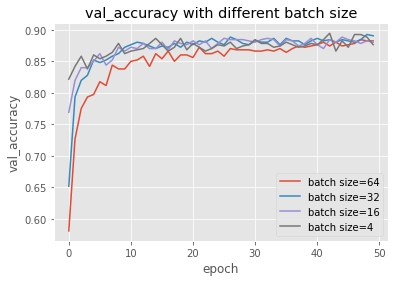

In [12]:
plt.style.use("ggplot")
plt.plot(history[0].history['val_accuracy'])
plt.plot(history[1].history['val_accuracy'])
plt.plot(history[2].history['val_accuracy'])
plt.plot(history[3].history['val_accuracy'])
plt.title('val_accuracy with different batch size')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['batch size=64', 'batch size=32','batch size=16','batch size=4'], loc='lower right')
plt.show()

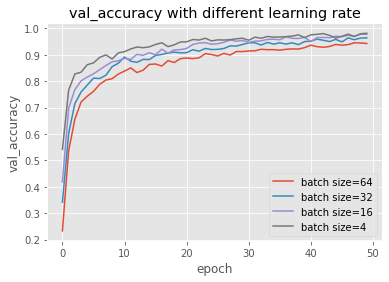

In [11]:
plt.style.use("ggplot")
plt.plot(history[0].history['accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[3].history['accuracy'])
plt.title('val_accuracy with different learning rate')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['batch size=64', 'batch size=32','batch size=16','batch size=4'], loc='lower right')
plt.show()